#  Automated Detection of Steel Surface Defects using Machine Learning & Computer Vision

### Problem Statement
Defects on steel surfaces — such as **scratches, inclusions, pitting, rolled-in scales, and patches** — reduce the quality, durability, and value of steel products.  
Manual inspection is labor-intensive, subjective, and prone to errors.

This notebook builds an **automated defect detection system** using **deep learning (CNNs + transfer learning)** on the **NEU Metal Surface Defect Dataset**.

---

### **Goal**
Train a **Convolutional Neural Network (CNN)** to:
- Automatically identify **6 types of steel surface defects**
- Evaluate model performance
- Visualize training results
- Predict defect type for **new images**

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

# Check GPU availability
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

2025-10-14 17:05:19.103172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760461519.315190      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760461519.380617      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Available GPUs: []


2025-10-14 17:05:33.294405: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


This imports all necessary deep learning, visualization, and data preprocessing libraries.  
The GPU check ensures TensorFlow can accelerate model training.

In [2]:
# Set dataset paths
train_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/train'
test_dir  = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test'
valid_dir = '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/valid'

# Verify directories
print("Train dir exists:", os.path.exists(train_dir))
print("Test dir exists:", os.path.exists(test_dir))
print("Valid dir exists:", os.path.exists(valid_dir))

# Class names from folders
class_names = sorted(os.listdir(train_dir))
print("Class names:", class_names)
num_classes = len(class_names)
print("Number of classes:", num_classes)

Train dir exists: True
Test dir exists: True
Valid dir exists: True
Class names: ['Crazing', 'Inclusion', 'Patches', 'Pitted', 'Rolled', 'Scratches']
Number of classes: 6


The dataset is structured into folders where each defect type is a class.  
The code automatically detects these class names for model training.

In [3]:
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator   = val_datagen.flow_from_directory(valid_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator  = test_datagen.flow_from_directory(test_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)

Found 1656 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Found 72 images belonging to 6 classes.


 Image augmentation helps improve model generalization by generating varied training samples.

In [4]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(256,256,3)),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Conv2D(512, (3,3), activation='relu', padding='same'),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         3,078 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,349,382 (70.00 MB)

 Trainable params: 18,349,382 (70.00 MB)

 Non-trainable params: 0 (0.00 B)

🧩 The CNN progressively extracts hierarchical features:
- Early layers capture edges and textures
- Deeper layers detect patterns like cracks, patches, etc.

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Precision', 'Recall'])

 The model is optimized using **Adam**, minimizing categorical cross-entropy loss for multi-class classification.

In [6]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3),
    ModelCheckpoint('best_model.keras', save_best_only=True)
]

⚡ Callbacks improve training stability and efficiency:
- Stops early if validation loss stops improving
- Saves the best model weights

In [7]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 215s 4s/step - Precision: 0.2534 - Recall: 0.0172 - accuracy: 0.2155 - loss: 1.8778 - val_Precision: 0.0000e+00 - val_Recall: 0.0000e+00 - val_accuracy: 0.3611 - val_loss: 1.5553 - learning_rate: 0.0010
Epoch 2/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 207s 4s/step - Precision: 0.5401 - Recall: 0.0508 - accuracy: 0.3304 - loss: 1.5607 - val_Precision: 0.4878 - val_Recall: 0.2778 - val_accuracy: 0.3472 - val_loss: 1.7822 - learning_rate: 0.0010
Epoch 3/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - Precision: 0.6284 - Recall: 0.1938 - accuracy: 0.4840 - loss: 1.3271 - val_Precision: 0.9444 - val_Recall: 0.2361 - val_accuracy: 0.4861 - val_loss: 1.1074 - learning_rate: 0.0010
Epoch 4/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 205s 4s/step - Precision: 0.7363 - Recall: 0.3303 - accuracy: 0.5829 - loss: 1.0883 - val_Precision: 0.7660 - val_Recall: 0.5000 - val_accuracy: 0.7361 - val_loss: 0.7713 - learning_rate: 0.0010
Epoch 5/25
52/52 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - Precisi

🚀 The model is trained for up to 25 epochs with live monitoring of validation loss and accuracy.

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 726ms/step


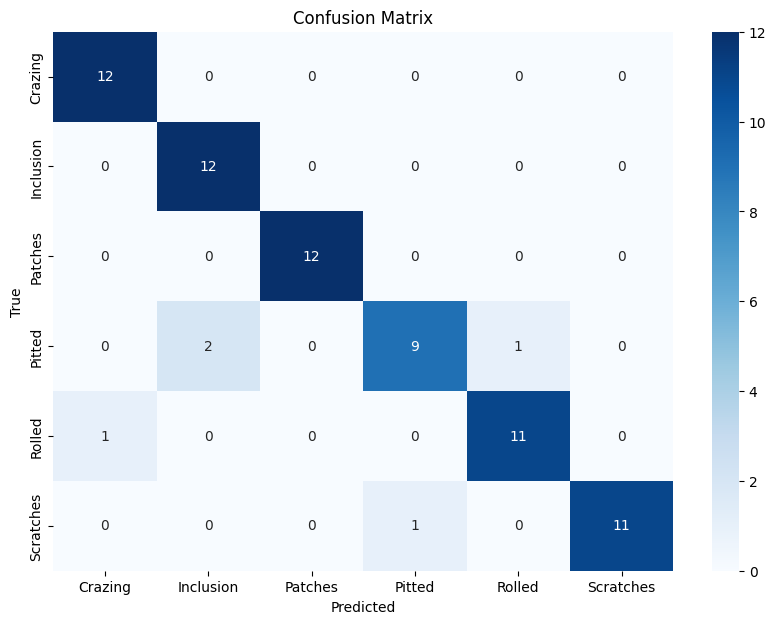

In [8]:
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = test_generator.classes

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

📊 Confusion matrix shows class-wise prediction performance — highlighting which defects are most commonly confused.

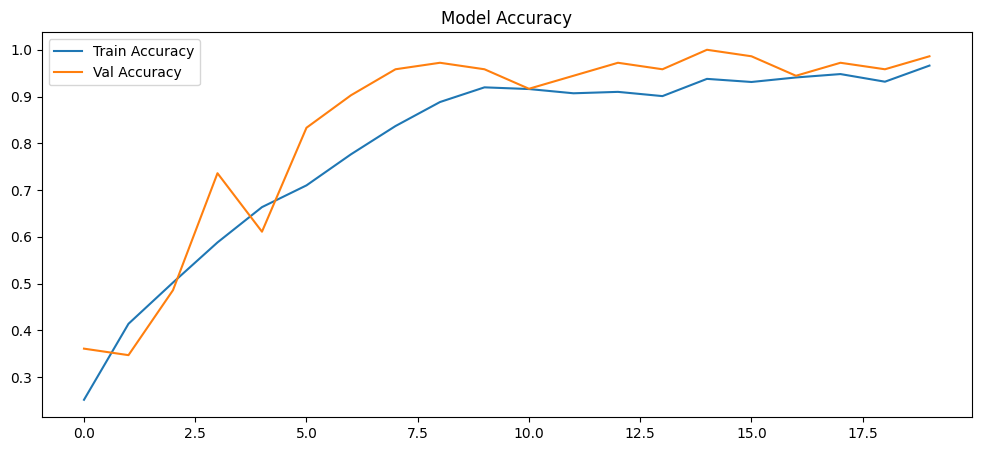

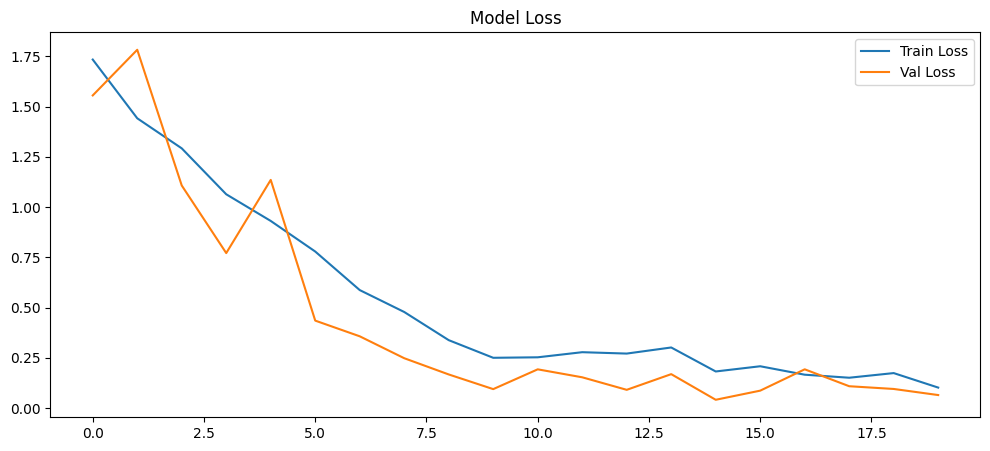

In [9]:
# Accuracy
plt.figure(figsize=(12,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Loss
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Model Loss')
plt.show()

📈 These graphs help visualize learning progress — ideally, both training and validation accuracy should rise and stabilize.

In [ ]:
model.save('final_steel_defect_model.keras')
print("✅ Model saved successfully!")

from tensorflow.keras.models import load_model
model = load_model('final_steel_defect_model.keras')

💾 Saving ensures the trained model can be reloaded for testing or deployment without retraining.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


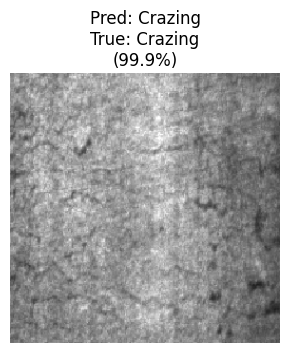

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import os

# List of image paths to predict
image_paths = [
    '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Crazing/Cr_103.bmp',
    # '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Inclusion/In_10.bmp',
    # '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Patches/Pa_1.bmp',
    # '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Pitted/PS_101.bmp',
    # '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Rolled/RS_100.bmp',
    # '/kaggle/input/neu-metal-surface-defects-data/NEU Metal Surface Defects Data/test/Scratches/Sc_1.bmp'
]

def predict_and_visualize(images_list, model, class_names, target_size=(256,256)):
    plt.figure(figsize=(len(images_list) * 3, 4))
    
    for idx, image_path in enumerate(images_list):
        img = load_img(image_path, target_size=target_size)
        img_array = img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        
        preds = model.predict(img_array)
        pred_class = class_names[np.argmax(preds)]
        confidence = np.max(preds)
        true_class = os.path.basename(os.path.dirname(image_path))
        
        plt.subplot(1, len(images_list), idx + 1)
        plt.imshow(img)
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}\n({confidence*100:.1f}%)")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# Call the function
predict_and_visualize(image_paths, model, class_names)

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 679ms/step


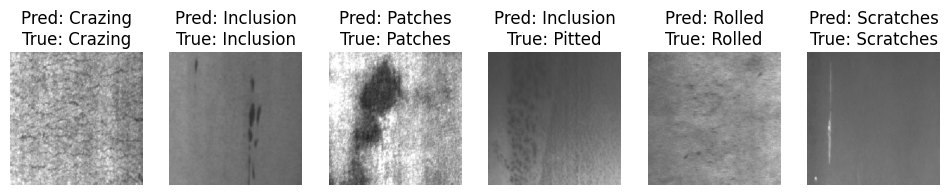

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_predictions_generator(model, test_generator, class_names):
    # Predict on all test images
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = test_generator.classes

    unique_classes = set()
    selected_indices = []

    # Find one example per class
    for i, label in enumerate(y_true):
        if label not in unique_classes:
            unique_classes.add(label)
            selected_indices.append(i)
        if len(unique_classes) == len(class_names):
            break

    # Plot predictions for selected indices
    plt.figure(figsize=(len(class_names) * 2, 3))
    for idx, sample_idx in enumerate(selected_indices):
        plt.subplot(1, len(class_names), idx + 1)
        # test_generator[index][0] gives batch of images
        # compute batch index and image index within batch
        batch_size = test_generator.batch_size
        batch_idx = sample_idx // batch_size
        img_idx = sample_idx % batch_size
        img = test_generator[batch_idx][0][img_idx]

        plt.imshow(img)
        pred_class = class_names[y_pred[sample_idx]]
        true_class = class_names[y_true[sample_idx]]
        plt.title(f"Pred: {pred_class}\nTrue: {true_class}")
        plt.axis('off')

    plt.show()

# Call the function
visualize_predictions_generator(model, test_generator, class_names)

📷 Predicts the defect type for a single image and visualizes both true and predicted labels.

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 670ms/step


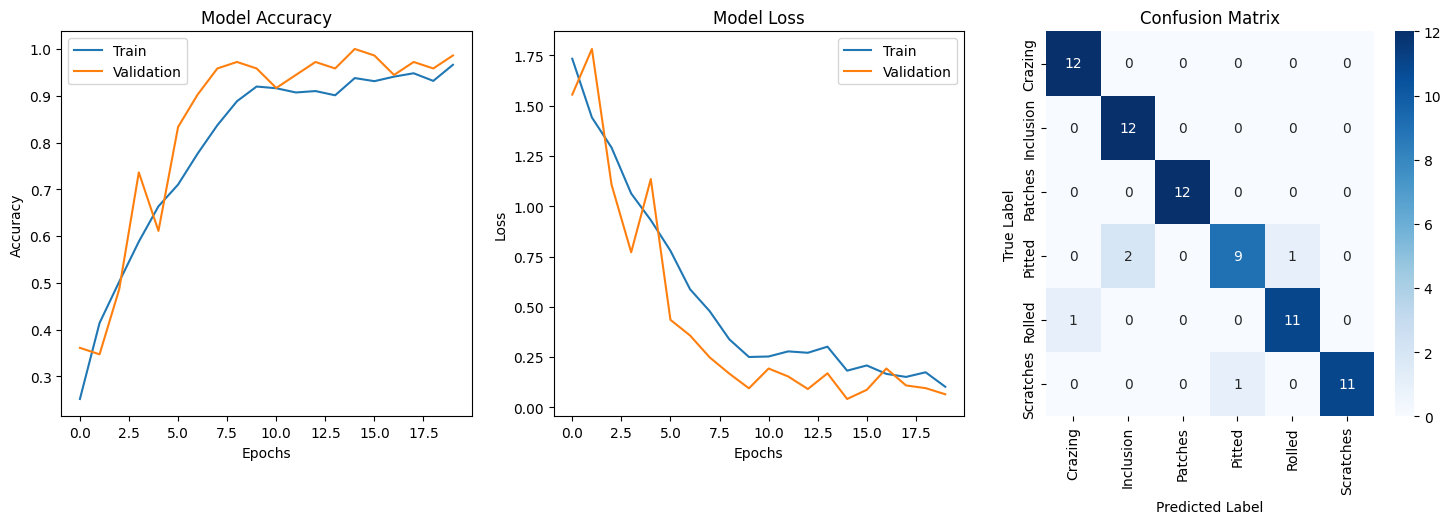

In [13]:
# Predict on test data
y_pred_probs = model.predict(test_generator)
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# True labels
y_true = test_generator.classes  # Already integer indices

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_training_history(history, y_true, y_pred, class_names):
    plt.figure(figsize=(18, 5))
    
    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'])
    
    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'])
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.subplot(1, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    
    plt.show()

# Call the function
plot_training_history(history, y_true, y_pred, class_names)